In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["SM_FRAMEWORK"] = "tf.keras"
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

In [2]:
!pip install -U segmentation-models --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import segmentation_models as sm
sm.set_framework('tf.keras')

In [6]:
# HYPERPARAMETERS FOR FINAL TRAINING
LAMBDA_ADV = 1.0 
# Removed CLASS_WEIGHTS due to numerical instability

print("Setup complete. Using a supervised UNet model with class weights.")

Setup complete. Using a supervised UNet model with class weights.


In [7]:
# Block B: Global Parameters and Data Loading
# ====================================================================================
IMAGE_SIZE = 512
BATCH_SIZE = 4 

root = '../input'
exts = ('jpg', 'JPG', 'png', 'PNG', 'tif', 'gif', 'ppm', '.jpeg')

# ====================== Source (DRIVE-AV) Dataset ========================
input_data = os.path.join(root, 'drive-av/test/images')
target_data = os.path.join(root, 'drive-av/test/label')

images = sorted(
    [
        os.path.join(input_data, fname)
        for fname in os.listdir(input_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)
masks = sorted(
    [
        os.path.join(target_data, fname)
        for fname in os.listdir(target_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)

print(f"Number of source samples (DRIVE-AV): {len(images)} images, {len(masks)} masks")

# ====================== Target (Diabetic Retinopathy) Dataset ========================
target_root = os.path.join(root, '/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped') 
target_images_full = sorted(
    [
        os.path.join(target_root, fname)
        for fname in os.listdir(target_root)
        if fname.endswith(('.jpeg')) and not fname.startswith(".")
    ]
)

target_images = target_images_full[:3000]

print(f"Number of target samples (Diabetic Retinopathy): {len(target_images)}")

Number of source samples (DRIVE-AV): 20 images, 20 masks
Number of target samples (Diabetic Retinopathy): 3000


In [8]:
# Block C: Data Generators
# ====================================================================================
import cv2
import numpy as np
import tensorflow as tf

def apply_clahe_np(image_np):
    """
    image_np: (H, W, 3) float32 numpy array in [0,1]
    returns enhanced float32 array in [0,1]
    """
    img = (image_np * 255).astype(np.uint8)

    # Extract green channel (best for vessels)
    g = img[:, :, 1]

    # Apply CLAHE to green channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    g_clahe = clahe.apply(g)

    # Replace green channel
    img[:, :, 1] = g_clahe

    # Convert back to float32
    return img.astype(np.float32) / 255.0

@tf.function
def apply_clahe_tf(image):
    """
    Wraps apply_clahe_np so it can be used in tf.data pipelines.
    """
    enhanced = tf.numpy_function(apply_clahe_np, [image], tf.float32)
    enhanced.set_shape(image.shape)  # important!
    return enhanced


@tf.function
def augment_image_only(image):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
    
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    
    return image

@tf.function
def augment_image_and_mask(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)
    
    return image, mask

def read_source_files(image_path, mask=False):
    image = tf.io.read_file(image_path)
    
    if mask:
        image = tf.io.decode_png(image, channels=3)
        red_channel = image[:, :, 0]
        blue_channel = image[:, :, 2]
        red_mask = tf.where(red_channel > 128, 1.0, 0.0)
        blue_mask = tf.where(blue_channel > 128, 1.0, 0.0)
        red_mask = tf.expand_dims(red_mask, axis=-1)
        blue_mask = tf.expand_dims(blue_mask, axis=-1)
        return tf.concat([red_mask, blue_mask], axis=-1)
    else:
        image = tf.io.decode_png(image, channels=3)
        image = tf.cast(image, tf.float32) / 255.0
        return image

def load_source_data(image_path, mask_path):
    image = read_source_files(image_path, mask=False)
    mask = read_source_files(mask_path, mask=True)
    
    image, mask = augment_image_and_mask(image, mask)
    
    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    mask = tf.image.resize(mask, size=[IMAGE_SIZE, IMAGE_SIZE])
    
    return image, mask

def source_data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_source_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    return dataset.repeat()

def read_dr_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image



@tf.function
def load_target_data(image_path):
    image = read_dr_image(image_path)
    image = apply_clahe_tf(image)
    image = augment_image_only(image)
    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    return image
    
def target_data_generator(image_list):
    image_tensor = tf.constant(image_list, dtype=tf.string)
    dataset = tf.data.Dataset.from_tensor_slices(image_tensor)
    dataset = dataset.map(load_target_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    return dataset.repeat()

source_dataset = source_data_generator(images, masks)
target_dataset_unlabeled = target_data_generator(target_images)
combined_dataset = tf.data.Dataset.zip((source_dataset, target_dataset_unlabeled))

I0000 00:00:1767172624.955052      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767172624.955723      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
# Block D: Model Definitions
# ====================================================================================
BACKBONE = 'vgg16'
n_classes = 2 
activation = 'sigmoid'

unet = sm.Unet(
    BACKBONE,
    classes=n_classes,
    activation=activation,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
    #encoder_weights= None
)

base_model = VGG16(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
encoder_model = Model(inputs=base_model.input, outputs=base_model.output)

def create_discriminator(input_shape): 
    inputs = keras.Input(shape=input_shape) 
    x = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(inputs) 
    x = layers.MaxPooling2D(pool_size=2)(x) 
    x = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(inputs) 
    x = layers.MaxPooling2D(pool_size=2)(x) 
    x = layers.Flatten()(x) 
    x = layers.Dense(256, activation='relu')(x) 
    outputs = layers.Dense(1, activation='sigmoid', name='domain_output')(x) 
    return keras.Model(inputs, outputs)


DISCRIMINATOR_INPUT_SHAPE = encoder_model.output_shape[1:]
discriminator = create_discriminator(DISCRIMINATOR_INPUT_SHAPE)


# Block E: Training Loop and Loss Function
# ====================================================================================
# FINAL FIXES: Balanced Learning Rates for a stable adversarial game
seg_optimizer = keras.optimizers.Adam(1e-4)
disc_optimizer = keras.optimizers.Adam(1e-6)

# FIXED: Revert to standard Dice Loss to fix numerical instability
seg_loss_fn = sm.losses.DiceLoss()
disc_loss_fn = keras.losses.BinaryCrossentropy()
adv_loss_fn = keras.losses.BinaryCrossentropy()

LAMBDA_ADV = 1.0


@tf.function
def train_step(source_images, source_masks, target_images, train_discriminator=True):
    source_labels = tf.zeros(tf.shape(source_images)[0], dtype=tf.float32)
    target_labels = tf.ones(tf.shape(target_images)[0], dtype=tf.float32)

    with tf.GradientTape() as disc_tape:
        source_features = encoder_model(source_images)
        target_features = encoder_model(target_images)
    
        source_features = tf.stop_gradient(source_features)
        target_features = tf.stop_gradient(target_features)

        disc_source_preds = discriminator(source_features)
        disc_target_preds = discriminator(target_features)

        disc_loss = disc_loss_fn(source_labels, disc_source_preds) + disc_loss_fn(target_labels, disc_target_preds)

    # ----------------------------------------------------
    # Train DISCRIMINATOR only if train_discriminator=True
    # ----------------------------------------------------
    if train_discriminator:
        disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))


    with tf.GradientTape() as seg_tape:
        seg_preds = unet(source_images, training=True)
        seg_loss = seg_loss_fn(source_masks, seg_preds) 

        source_features_adv = encoder_model(source_images)
        target_features_adv = encoder_model(target_images)
        disc_source_preds_adv = discriminator(source_features_adv)
        disc_target_preds_adv = discriminator(target_features_adv)
        
        adv_source_loss = adv_loss_fn(target_labels, disc_source_preds_adv)
        adv_target_loss = adv_loss_fn(target_labels, disc_target_preds_adv)
        total_adv_loss = adv_source_loss + adv_target_loss
        
        total_seg_loss = seg_loss + (LAMBDA_ADV * total_adv_loss) 
    
    seg_grads = seg_tape.gradient(total_seg_loss, unet.trainable_variables)
    seg_optimizer.apply_gradients(zip(seg_grads, unet.trainable_variables))

    return total_seg_loss, seg_loss, total_adv_loss, disc_loss

num_source_images = len(images)
steps_per_epoch = num_source_images // BATCH_SIZE
if steps_per_epoch == 0:
    steps_per_epoch = 1

epochs = 400 
print(f"Starting supervised training for {epochs} epochs with {steps_per_epoch} steps per epoch...")

for epoch in range(epochs):
    print(f"Starting Epoch {epoch+1}")

    for step, ((source_images, source_masks), target_images) in enumerate(iter(combined_dataset)):
        if step >= steps_per_epoch:
            break
        
        # ---------------------------------------------------
        # Train discriminator only every 2 steps
        # ---------------------------------------------------
        train_disc = (step % 2 == 0)

        total_seg_loss, sup_loss, adv_loss, disc_loss = train_step(
            source_images, 
            source_masks, 
            target_images,
            train_discriminator=train_disc  # <-- NEW FLAG
        )

        if (step + 1) % 10 == 0:
            print(f"Step {step+1}/{steps_per_epoch}: "
                  f"Seg Loss: {total_seg_loss:.4f}, "
                  f"Supervised Loss: {sup_loss:.4f}, "
                  f"Adversarial Loss: {adv_loss:.4f}, "
                  f"Discriminator Loss: {disc_loss:.4f} (train={train_disc})")

    print(f"\nEpoch {epoch+1} finished.\n")
    print(f"Final epoch metrics: Seg Loss: {total_seg_loss:.4f}, Supervised Loss: {sup_loss:.4f}, Adversarial Loss: {adv_loss:.4f}, Discriminator Loss: {disc_loss:.4f}\n")

print("Training finished. Saving the model...")
unet.save('vgg16_unet400_DREnhanced_model.keras')
print("Model saved successfully!")

In [9]:
import os
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
import numpy as np
import matplotlib.pyplot as plt

IMAGE_SIZE = 512
# The model name you used to save the file
MODEL_FILE_NAME = '/kaggle/input/dr-vesselseg-vgg16-clahe/keras/default/1/vgg16_unet400_DREnhanced_model.keras' 
custom_objects = {'dice_loss': sm.losses.dice_loss}

try:
    unet = keras.models.load_model(MODEL_FILE_NAME, custom_objects=custom_objects)
    print(f"Model '{MODEL_FILE_NAME}' loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure the model file exists and the path is correct.")
    # Exit if the model can't be loaded
    exit()

Model '/kaggle/input/dr-vesselseg-vgg16-clahe/keras/default/1/vgg16_unet400_DREnhanced_model.keras' loaded successfully!


Predicting mask for image: 1000_right.jpeg


I0000 00:00:1767172681.978158     116 service.cc:148] XLA service 0x7b2790001c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767172681.979045     116 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767172681.979065     116 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767172682.254849     116 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1767172690.031780     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


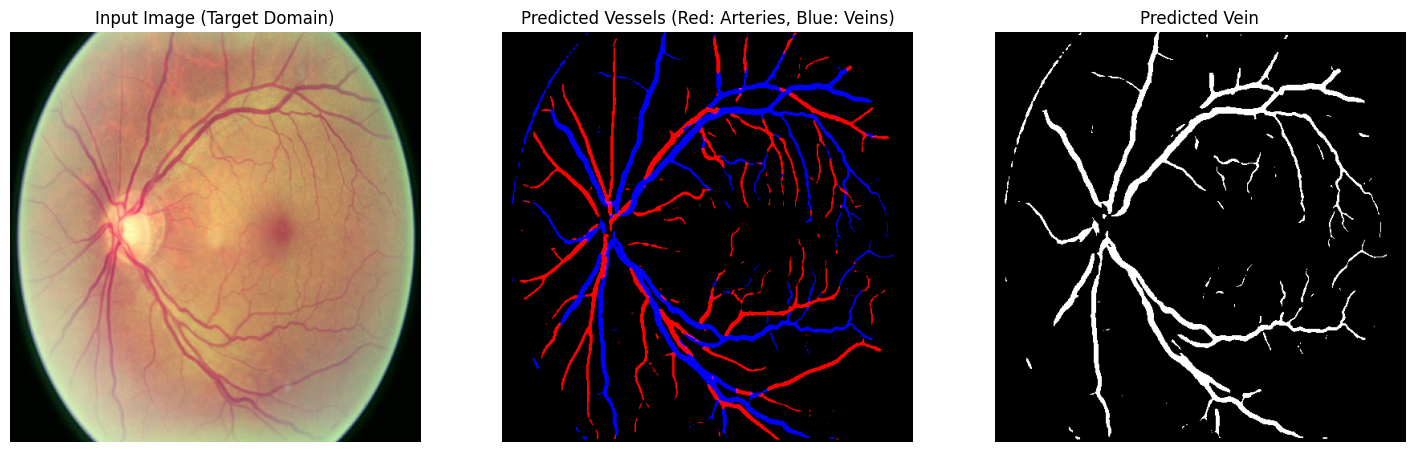

Predicting mask for image: 10031_left.jpeg


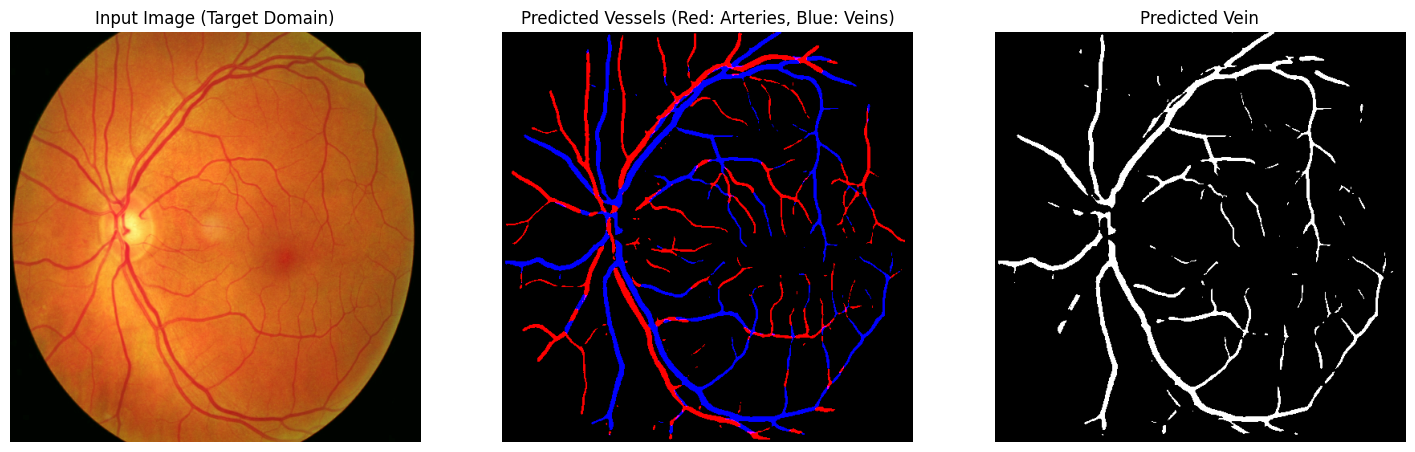

In [11]:
import cv2
import numpy as np
import tensorflow as tf

def apply_clahe_np(image_np):
    """
    image_np: float32 numpy array in [0,1], shape (H,W,3)
    CLAHE applied on green channel.
    """
    img = (image_np * 255).astype(np.uint8)
    g = img[:, :, 1]

    # CLAHE on green channel only
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    g_clahe = clahe.apply(g)

    img[:, :, 1] = g_clahe
    return img.astype(np.float32) / 255.0


@tf.function
def apply_clahe_tf(image):
    enhanced = tf.numpy_function(apply_clahe_np, [image], tf.float32)
    enhanced.set_shape(image.shape)
    return enhanced

def preprocess_for_inference(image_path):
    # Load and normalize
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    
    # CLAHE (same as training)
    image = apply_clahe_tf(image)

    return image

def predict_single_image(image_path, model):
    image_tensor = preprocess_for_inference(image_path)
    image_tensor = tf.expand_dims(image_tensor, axis=0)

    pred_mask = model.predict(image_tensor, verbose=0)
    pred_mask = (pred_mask > 0.5).astype("float32")

    pred_artery = pred_mask[0, :, :, 0]
    pred_vein   = pred_mask[0, :, :, 1]

    return image_tensor[0], pred_artery, pred_vein


def display_prediction_results(original_image, predicted_artery, predicted_vein):
    combined_mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
    combined_mask[:, :, 0] = predicted_artery
    combined_mask[:, :, 2] = predicted_vein

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title('Input Image (Target Domain)')
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Predicted Vessels (Red: Arteries, Blue: Veins)')
    plt.imshow(combined_mask)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Vein')
    plt.imshow(predicted_vein, cmap='gray')
    plt.axis('off')

    plt.show()


target_root = '/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped' 
sample_images = [
    '1000_right.jpeg', 
    '10031_left.jpeg'
]

for image_name in sample_images:
    image_path = os.path.join(target_root, image_name)

    if os.path.exists(image_path):
        print(f"Predicting mask for image: {image_name}")
        original_image, pred_artery, pred_vein = predict_single_image(image_path, unet)
        display_prediction_results(original_image, pred_artery, pred_vein)
    else:
        print("Image not found:", image_path)
